<a href="https://colab.research.google.com/github/RuslanFF1968/Pioneer/blob/main/Voice_command_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import of libraries**



In [ ]:
import numpy as np # библиотека для работы с массивами данных
from matplotlib import pyplot as plt # интерфейс для построения графиков простых функций
from IPython.display import Audio # загружаем модуль чтобы обратиться к HTML для записи аудио с микрофона в ноутбуке
from google.colab import files # модуль для загрузки файлов
import librosa # для параметризации аудио
import os # модуль для работы с операционной системой(воспользуемся методами работы с каталогами)
from sklearn.model_selection import train_test_split # модуль для разбивки данных на обучающую и тестовую выборки
from tensorflow.keras.utils import to_categorical # загружаем утилиты кераса для one hot кодировки
from tqdm import tqdm # быстрый, удобный progress bar для Python
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta # загружаем алгоритмы обучения/оптимизации
from tensorflow.keras.models import Sequential # последовательная модель нейросети кераса
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Reshape # загружаем необходимые слои для нейросети
import IPython.display as ipd # Воспроизведение звуковыйх файлов

In [ ]:
import gdown

url = 'https://drive.google.com/uc?id=1U-sc0uTV9DhIS2B86RBOVm5rqeeosBGq'
output = 'comands.zip'
# Загружаем файл
gdown.download(url, output, quiet=False)

url = 'https://drive.google.com/uc?id=10EeLCc0gl53a5-jRlQRwfVPxVK6U-gaZ'
output = 'test_speech.zip'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1U-sc0uTV9DhIS2B86RBOVm5rqeeosBGq
From (redirected): https://drive.google.com/uc?id=1U-sc0uTV9DhIS2B86RBOVm5rqeeosBGq&confirm=t&uuid=7d0cb505-0c00-454a-af2d-1e0e506a255b
To: /content/comands.zip
100%|██████████| 116M/116M [00:03<00:00, 35.9MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=10EeLCc0gl53a5-jRlQRwfVPxVK6U-gaZ
From (redirected): https://drive.google.com/uc?id=10EeLCc0gl53a5-jRlQRwfVPxVK6U-gaZ&confirm=t&uuid=846a8f1e-f53d-40f0-9022-c8a9136eb8f4
To: /content/test_speech.zip
100%|██████████| 105M/105M [00:01<00:00, 52.8MB/s]


'test_speech.zip'

In [ ]:
!unzip -q '/content/comands.zip' #распаковываем архив на локальный диск google colaboratory

In [ ]:
!unzip -q '/content/test_speech.zip' #распаковываем архив на локальный диск google colaboratory

In [ ]:
# Зададим параметры данных, к-е пойдут на вход нейросети
DATA_PATH = "/content/comands/" # зададим путь к папке с аудиофайлами
DATA_PATH_TEST = "/content/test_speech/" # Зададим пусть к файлу с тестовыми 30секнудными аудиофайлами

sample_rate = 22050 # Значение sample_rate аудиофайлов
feature_dim_1 = 20 # стандартная величина MFCC признаков
feature_dim_2 = int(.5 * sample_rate) # установленная длина фреймов (в секундах 0.5 = 500 мс)
step_mfcc = int(.02 * sample_rate) # Шаг смещения при разборе mfcc (в секундах 0.1 = 100мс)
channel = 1 # количество каналов
n_classes = 4 # Количество классов команд
classes = ['КОНДИЦИОНЕР', 'СВЕТ', 'ТЕЛЕВИЗОР'] # Классы команд (без фона)

# Declaration of functions



In [ ]:
'''
Зададим функцию извлечения лейблов классов и их обработки
  Параметры:
    path - путь к папке, в которой находятся каталоги с обучающими командами
'''

def get_labels(path=DATA_PATH):
  labels = sorted(os.listdir(path)) # запишем лейблы классов по названию папок с данными - ['кондиционер', 'телевизор', 'свет', 'фон']
  label_indices = np.arange(0, len(labels)) # запишем лейблы в виде индексов - [0, 1, 2, 3]
  return labels, label_indices, to_categorical(label_indices) # функция вернёт лейблы, индексы лейблов и их one-hot представление[0, 1, 0, 0]

In [ ]:
l,_,_ = get_labels()
l

['1_cond', '2_light', '3_tv', '4_noise']

In [ ]:
'''
Создаем функцию параметризации аудио(wav в мел-частоты)
  Параметры:
    length - длинна отрезков, на которые разбиваем исходный файл
    step - шаг, на который смещаем разбиение отрезка
'''

def wav2mfcc(file_path, length = 11025, step = 2205):
  out_mfcc = [] # Выходной массив, содержащий mfcc исходного файла с шагом step
  out_audio = [] # Выходной массив, содеражищий аудиоинформацию исходного файла с шагом step
  y, sr = librosa.load(file_path, sr=22050) # Загружаем данные исходного файла

  while (len(y)>=length):  # Проходим весь массив y, пока оставшийся кусочек не станет меньше указанной в параметре max_len длинны
    section = y[:length] # Берем начальный кусок длинной length
    section = np.array(section) # Переводим в numpy
    out_mfcc.append(librosa.feature.mfcc(y=section, sr=sr, n_mfcc=feature_dim_1)) # Добавляем в выходной массив out_mfcc значение mfcc текущего куска
    out_audio.append(section) # Добавляем в выходной массив аудио текущий кусок
    y = y[step:]  # Уменьшаем y на step

  out_mfcc = np.array(out_mfcc) # Преобразуем в numpy)
  out_audio = np.array (out_audio) # Преобразуем в numpy
  return out_mfcc, out_audio # функция вернет массив мэл-частот и массив аудио-отрезков

In [ ]:
def wav2mfcc(file_path, length=11025, step=2205):
  out_mfcc = []
  out_audio = []
  y, sr = librosa.load(file_path, sr=sample_rate) # Указываем sample_rate явно

  while len(y) >= length:
    section = y[:length]
    mfcc_feat = librosa.feature.mfcc(y=section, sr=sr, n_mfcc=feature_dim_1)
    out_mfcc.append(mfcc_feat)
    out_audio.append(section)
    y = y[step:]

  return np.array(out_mfcc), np.array(out_audio)

In [ ]:
'''
Объявим функцию формирования и сохранения векторов данных, полученных для каждого набора аудио-команд в датасете
  Параметры:
    path  - путь к папке, в которой находятся каталоги с обучающими командами
    length - длинна отрезков, на которые разбиваем исходный файл
'''

def save_data_to_array(path=DATA_PATH, length=11025):
  labels, _, _ = get_labels(path) # запишем лейблы классов
  for label in labels: # для каждого лейбла
    mfcc_vectors = [] # здесь соберем векторы MFCC частот
    wavfiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
    for wavfile in tqdm(wavfiles, "Сохраняем векторы класса - '{}'".format(label)): # для каждого файла
      mfcc, _ = wav2mfcc(wavfile, length=length, step = step_mfcc) # получим мел-частоты
      if (mfcc.shape[0] != 0 ): # Если массив не нулевой длинны
        mfcc_vectors.extend(mfcc) # и добавим вектор в список для соответствующего класса
    np.save(label + '.npy', mfcc_vectors) # сохраним массивы данных для каждого класса

In [ ]:
'''
Создадим функцию для получения обучающей/проверочной выборки
  Параметры (необязательные):
    split_ratio - (1-split_ratio) равно доле тестовых образцов, которые вернет функция train_test_split
    random_state - начальное число, используемое генератором случайных чисел в финкции train_test_split
'''

def get_train_test(split_ratio=0.7, random_state=42, colab = True):
  labels, indices, _ = get_labels(DATA_PATH) # извлекаем имена и индексы лейблов классов

  # Getting first arrays
  X = np.load('/content/'+labels[0] + '.npy') # берем набор векторов для первого класса
  y = np.zeros(X.shape[0], dtype = 'int32') # устанавливаем размер соответствующего ему лейбла

  # Объединяем в единый датасет в виде np-массива обучающий и проверочный набор данных
  for i, label in enumerate(labels[1:]):
    if colab:
      x = np.load(label + '.npy') # Читаем очередной массив данных
    else:
      x = np.load('/content/'+label + '.npy') # Читаем очередной массив данных
    X = np.vstack((X, x)) # Соединяем с исходным набором
    y = np.append(y, np.full(x.shape[0], fill_value= (i + 1))) # В массив y добавлем x.shape[0]-элеменентов со значением (i + 1)

  return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True) # Разделяем данные на обучающую и проверочную выборки

In [ ]:
# Формируем и сохраняем векторы данных, полученных для каждого набора аудио-команд в датасете
save_data_to_array(length=feature_dim_2)

Сохраняем векторы класса - '4_noise': 100%|██████████| 50/50 [06:04<00:00,  7.28s/it]


In [ ]:
def train_test(split_ratio = 0.7):
  x_train, x_test, y_train, y_test = get_train_test(split_ratio=split_ratio, colab=False) # создаем обучающий/проверочный наборы

  # Добавляем значение канала(=1) в размеры 'x' выборок
  x_train = x_train[..., None]
  x_test = x_test[..., None]

  y_train_hot = to_categorical(y_train) # представляем лейблы классов обучающего набора в виде one-hot вектора ((0, 1, 0) и т.п)
  y_test_hot = to_categorical(y_test) # представляем лейблы классов проверочного набора в виде one-hot вектора ((0, 1, 0) и т.п)
  return x_train, x_test, y_train_hot, y_test_hot

In [ ]:
def train_model(neurons, batch_size, epochs, split_ratio=0.7):
    x_train, x_test, y_train_hot, y_test_hot = train_test(split_ratio=split_ratio)

    def get_model(neurons):
        model = Sequential()
        model.add(Conv2D(8, kernel_size=(3, 3), activation='relu',
                         input_shape=(x_train.shape[1], x_train.shape[2], channel)))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(BatchNormalization())
        model.add(Flatten())
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(0.25))
        model.add(BatchNormalization())
        model.add(Dense(n_classes, activation='softmax'))
        model.compile(loss='categorical_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        return model

    model = get_model(neurons=neurons)  # Используем переданный параметр neurons вместо жестко заданного значения 128

    history = model.fit(x_train, y_train_hot,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test_hot))

    # Визуализация точности
    plt.plot(history.history['accuracy'], label='Доля верных ответов на обучающем наборе')
    plt.plot(history.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Доля верных ответов')
    plt.legend()
    plt.show()

    return model  # Важно: возвращаем обученную модель

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.7020 - loss: 0.8088 - val_accuracy: 0.9824 - val_loss: 0.0539
Epoch 2/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9870 - loss: 0.0491 - val_accuracy: 0.9910 - val_loss: 0.0278
Epoch 3/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9917 - loss: 0.0271 - val_accuracy: 0.9938 - val_loss: 0.0186
Epoch 4/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9930 - loss: 0.0207 - val_accuracy: 0.9941 - val_loss: 0.0171
Epoch 5/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9933 - loss: 0.0183 - val_accuracy: 0.9950 - val_loss: 0.0152
Epoch 6/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9950 - loss: 0.0148 - val_accuracy: 0.9965 - val_loss: 0.0105
Epoch 7/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9957 - loss: 0.0114 - val_accuracy: 0.9951 - val_loss: 0.0146
Epoch 8/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9949 - loss: 0.0139 - val_accuracy: 0

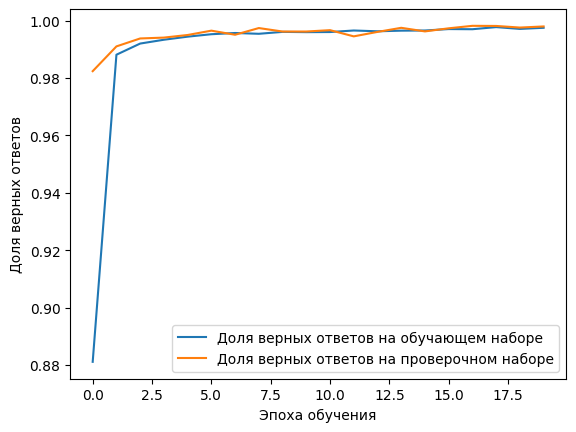

In [ ]:
model = train_model(neurons=128, batch_size=256, epochs=20, split_ratio=0.7)

### Step by step



In [ ]:
wavfiles =  DATA_PATH_TEST + 'text_with_cond3.wav' # Получаем имя очередного файла
y,sr = librosa.load(wavfiles) # Загружаем данные модулем librosa
print ('Оригинальный файл:')
ipd.Audio(data=y, rate = sr) # Выводим оригинальный аудиофайл (Команда "Кондиционер" начинается на 12 секунде)

Оригинальный файл:


In [ ]:
mfcc_full, audio_full = wav2mfcc (wavfiles, length=feature_dim_2, step = step_mfcc) # Получаем массив mfcc выбранного файла с именем namefile

mfcc_full = mfcc_full.reshape(-1, 20, 22, 1) # Решейпим для сверточного слоя
g_pred = model.predict(mfcc_full) # Предиктим с помощью модели model массив mfcc
pred = np.array([np.argmax(i) for i in g_pred]) # Выбираем индекс максимального элемента в каждом g_pred[i]  и создаем numpy-массив pred из этих индексов

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [ ]:
print(g_pred.shape)
print(pred.shape)
print(pred[:800])

(1426, 4)
(1426,)
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 

In [ ]:
idxs = np.where(pred == 0) # В массиве pred находим все элементы со значением, равным искомому классу idx_class
idxs = idxs[0] # Размерность полученного маасива в np.where иммет тип (x,). Оставляем только первую размерность

print (idxs)

[230]


In [ ]:
curr = [] # Временный массив для хранения информации о найденных командах
'''
в массиве idx данные могут быть прдеставлены следующим образом:
[4, 5, 6, 7, 123, 124, 125, 126, 127]
в массив curr мы запишем [4, 123] только стартовые индексы
поскольку очевидно, что 4,5,6,7 и 123,124,125,126,127 представляют единую команду
'''
curr_idx =int (idxs[0]) # Текущий стартовый индекс
summ, length = 0, 0 # summ - хранит сумму вероятностей, с которой сеть отнесла команду к данному классу; length - длинна последовательно идущих элементов для одной команды (для массива curr из примера
                                                              #[4, 123] длина соответствующая первому элементу будет 4, второму - 5 )
for i in range(len(idxs)): # Пробегаем по всему массиву idxs
  summ += g_pred[idxs[i]][0] # Считаем сумму вероятности
  length += 1 # Увеличиваем длинну последовательности
  if i == len(idxs)-1: # Если последний элемент последовательности
    if (length >= 2 and summ / length >= 0.95): # Проверяем на условия разбора: длинна последовательности должна быть больше входного параметра min_count
                                                        # summ / length должно быть больше входного параметра rate
      curr.append([curr_idx, length, summ / length]) # Если условия выполняются, то добавляем в маасив стартовый индекс найденной команды, длинну последовательности и summ / length
    break
  if idxs[i+1]-idxs[i]>1: # Если следующий индекс больше текущего на 1 (означает, что следующий элемент относится уже к другой комманде)
    if (length >= 8 and summ / length >= 0.95): # Проверяем на условия разбора: длинна последовательности должна быть больше входного параметра min_count
                                                        # summ / length должно быть больше входного параметра rate
      curr.append([curr_idx, length, summ / length]) # Если условия выполняются, то добавляем в маасив стартовый индекс найденной команды, длинну последовательности и summ / length
    curr_idx = int (idxs[i+1]) # Изменяем текущий стартовый индекс
    summ, length = 0, 0 # Обнуляем summ и length
print (curr)

[]


In [ ]:
np_Audio = []
curr_audio = [] # mfcc отдельной команды
for elem in curr: # Проходим по всему массиву curr
  curr_audio = audio_full[elem[0]]
  if (elem[0] != 0): # Если это не самый первый элемент исходных данных, то возьмем на одну mfcc левее (чаще всего там будет либо тишина, либо начало команды, которое не разобралось сетью)
    curr_audio = np.hstack((audio_full[elem[0] - 1], audio_full[elem[0]][-step_mfcc:]))
  for j in range(1,elem[1]): # Пробегаем цикл от 1 до elem[1] (где elem[1] хранит длинну последовательности элементов, отнесенных к одной команде)
    if (elem[0]+j == len(audio_full)): # Если elem[0] + j равно длинне mfcc, то выходим из цикла
      break
    curr_audio = np.hstack((curr_audio, audio_full[elem[0]+j][-step_mfcc:]))
  curr_audio = np.array(curr_audio) # Переводим массив в numpy
  np_Audio.append([curr_audio, elem[2]]) # Добавляем данные в выходной массив

print (len(curr_audio))


0


In [ ]:
if (len(np_Audio)==0): # Если длина массива равна 0, то команда не распознана
    print('Команда не распознанана!!!')
for elem in np_Audio: # Пробегам по всем элементам массива out
    print ('Распознана команда: "', classes[0], '" (вероятность - %.2f' % (elem[1]*100), '%)') # Выводим название
    ipd.display(ipd.Audio (elem[0], rate = 22050))

Команда не распознанана!!!


### Function



In [ ]:
##########################
# Объявим функцию предсказания команды
##########################
def predict(namefile, model, min_count = 2, rate = 0.9, hole = 1): # функция принимает на вход путь к нужному файлу, и имя обученной модели
  mfcc_full, audio_full = wav2mfcc (namefile, length=feature_dim_2, step = step_mfcc) # Получаем массив mfcc выбранного файла с именем namefile

  #mfcc = xScaler.transform(mfcc_full.reshape(-1,1))
  mfcc_full = mfcc_full.reshape(-1, 20, 22, 1)
  g_pred = model.predict(mfcc_full) # Предиктим с помощью модели model массив mfcc
  pred = np.array([np.argmax(i) for i in g_pred]) # Выбираем индекс максимального элемента в каждом g_pred[i]  и создаем numpy-массив pred из этих индексов

  out = [] # Объявляем выходную переменную out (В ней будут храниться преобразованные из mfcc ауидоданные, класс команды и точность, с которой сеть считает эту команду верной)
  # Ищем команды каждого класса
  for idx_class in range(n_classes-1):
    idxs = np.where(pred == idx_class) # В массиве pred находим все элементы со значением, равным искомому классу idx_class
    idxs = idxs[0] # Размерность полученного маасива в np.where иммет тип (x,). Оставляем только первую размерность
    if (len(idxs) == 0): # Если элементы искомого класса не найдены,
      continue # то переходим к поиску команд следующего класса

    curr = [] # Временный массив для хранения информации о найденных командах
    '''
    в массиве idx данные прдеставлены следующим образом:
    [4, 5, 6, 7, 123, 124, 125, 126, 127]
    в массив curr мы запишем [4, 123] только стартовые индексы
    поскольку очевидно, что 4,5,6,7 и 123,124,125,126,127 представляют единую команду
    '''
    curr_idx =int(idxs[0]) # Текущий стартовый индекс
    summ, length = 0, 0 # summ - хранит сумму вероятностей, с которой сеть отнесла команду к данному классу; length - длинна последовательно идущих элементов для одной команды (для массива curr из примера
                                                                  #[4, 123] длина соответствующая первому элементу будет 4, второму - 5 )
    for i in range(len(idxs)): # Пробегаем по всему массиву idxs
      summ += g_pred[idxs[i]][idx_class] # Считаем сумму вероятности
      length += 1 # Увеличиваем длинну последовательности
      if i == len(idxs)-1: # Если последний элемент последовательности
        if (length >= min_count and summ / length >= rate): # Проверяем на условия разбора: длинна последовательности должна быть больше входного параметра min_count
                                                            # summ / length должно быть больше входного параметра rate
          curr.append([curr_idx, length, summ / length]) # Если условия выполняются, то добавляем в маасив стартовый индекс найденной команды, длинну последовательности и summ / length

        break
      if idxs[i+1]-idxs[i]>hole: # Если следующий индекс больше текущего на hole (означает, что следующий элемент относится уже к другой комманде)
        if (length >= min_count and summ / length >= rate): # Проверяем на условия разбора: длинна последовательности должна быть больше входного параметра min_count
                                                            # summ / length должно быть больше входного параметра rate
          print(length)
          curr.append([curr_idx, length, summ / length]) # Если условия выполняются, то добавляем в маасив стартовый индекс найденной команды, длинну последовательности и summ / length
        curr_idx = int (idxs[i+1]) # Изменяем текущий стартовый индекс
        summ, length = 0, 0 # Обнуляем summ и length
    curr_audio = [] # mfcc отдельной команды
    for elem in curr: # Проходим по всему массиву curr
      #if (elem[0] != 0): # Если это не самый первый элемент исходных данных, то возьмем на одну mfcc левее (чаще всего там будет либо тишина, либо начало команды, которое не разобралось сетью)
      #  curr_audio = np.concatenate((audio_full[elem[0] - 1], audio_full[elem[0]][:, -step_mfcc:,:]), axis = 0)
      #else:
      curr_audio = audio_full[elem[0]] # Если это стартовый элемент исходных данных, то берем самую первую mfcc
      for j in range(1,elem[1]): # Пробегаем цикл от 1 до elem[1]+1 (где elem[1] хранит длинну последовательности элементов, отнесенных к одной команде)
        if (elem[0]+j == len(audio_full)): # Если elem[0] + j равно длинне mfcc, то выходим из цикла
          break
        #curr_audio = np.concatenate((curr_audio, audio_full[elem[0] + j][:,-step_mfcc:,:]), axis = 1) # Создаем единий mfcc, использую concatenate для добавления к текущему значению срез динной step_mfcc из следующего элемента
        curr_audio = np.hstack((curr_audio, audio_full[elem[0]+j][-step_mfcc:]))
      curr_audio = np.array(curr_audio) # Переводим массив в numpy
      #curr_mfcc = curr_mfcc.reshape (curr_mfcc.shape[0], curr_mfcc.shape[1]) # Убираем третью размерность
      #curr_mfcc_unscaled= xScaler.inverse_transform(curr_mfcc)
      #recon = librosa.feature.inverse.mfcc_to_audio(curr_mfcc_unscaled) # Получаем ауди из mfcc
      out.append([curr_audio, idx_class, elem[2]]) # Добавляем данные в выходной массив
  return out, pred, g_pred # Возращаем массив с данными, массив с классами команд, массив с softmax данными

In [ ]:
wavfiles =  DATA_PATH_TEST + 'text_with_cond14.wav' # Получаем имя очередного файла
out, pred, _ = predict(wavfiles, model=model, min_count = 6, rate = 0.8, hole = 2)  # Вызываем predict для очередного файла
if (len(out)==0): # Если длинна массива равна 0, то команда не распознана
  print('Команда не распознанана!!!')
for elem in out: # Пробегам по всем элементам массива out
  print ('Распознана команда: "', classes[elem[1]], '" (вероятность - %.2f' % (elem[2]*100), '%)') # Выводим название
  ipd.display(ipd.Audio (elem[0], rate = 22050))


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Команда не распознанана!!!


In [ ]:
wavfiles =  DATA_PATH_TEST + 'text_with_cond7.wav' # Получаем имя очередного файла
out, pred, _ = predict(wavfiles, model=model, min_count = 6, rate = 0.9, hole = 1)  # Вызываем predict для очередного файла
if (len(out)==0): # Если длинна массива равна 0, то команда не распознана
  print('Команда не распознанана!!!')
for elem in out: # Пробегам по всем элементам массива out
  print ('Распознана команда: "', classes[elem[1]], '" (вероятность - %.2f' % (elem[2]*100), '%)') # Выводим название
  ipd.display(ipd.Audio (elem[0], rate = 22050))


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Команда не распознанана!!!


In [ ]:
wavfiles =  DATA_PATH_TEST + 'text_with_televizor'+str(6)+'.wav' # Получаем имя очередного файла
out, pred, _ = predict(wavfiles, model=model, min_count = 10, rate = 0.98, hole = 1)  # Вызываем predict для очередного файла
if (len(out)==0): # Если длинна массива равна 0, то команда не распознана
  print('Команда не распознанана!!!')
for elem in out: # Пробегам по всем элементам массива out
  print ('Распознана команда: "', classes[elem[1]], '" (вероятность - %.2f' % (elem[2]*100), '%)') # Выводим название
  ipd.display(ipd.Audio (elem[0], rate = 22050))

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Команда не распознанана!!!


In [ ]:
# Уменьшим параметр rate до 0.75
wavfiles =  DATA_PATH_TEST + 'text_with_svet'+str(12)+'.wav' # Получаем имя очередного файла
out, pred, _ = predict(wavfiles, model=model, min_count = 2, rate = 0.8, hole = 1)  # Вызываем predict для очередного файла
if (len(out)==0): # Если длинна массива равна 0, то команда не распознана
  print('Команда не распознанана!!!')
for elem in out: # Пробегам по всем элементам массива out
  print ('Распознана команда: "', classes[elem[1]], '" (вероятность - %.2f' % (elem[2]*100), '%)') # Выводим название
  ipd.display(ipd.Audio (elem[0], rate = 22050))

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Команда не распознанана!!!
